In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
raw_data = fetch_california_housing()
data = raw_data.data 

In [3]:
lower_percent = np.percentile(data, 1, axis=0)
higher_percent = np.percentile(data, 99, axis=0)

result = np.array([True for i in range(data.shape[0])])
for i in range(len(raw_data.feature_names)):
    lower = data[:,i] >= lower_percent[i]
    higher = data[:,i] <= higher_percent[i]
    result = np.logical_and(result, np.logical_and(lower, higher))
    
data = data[result]

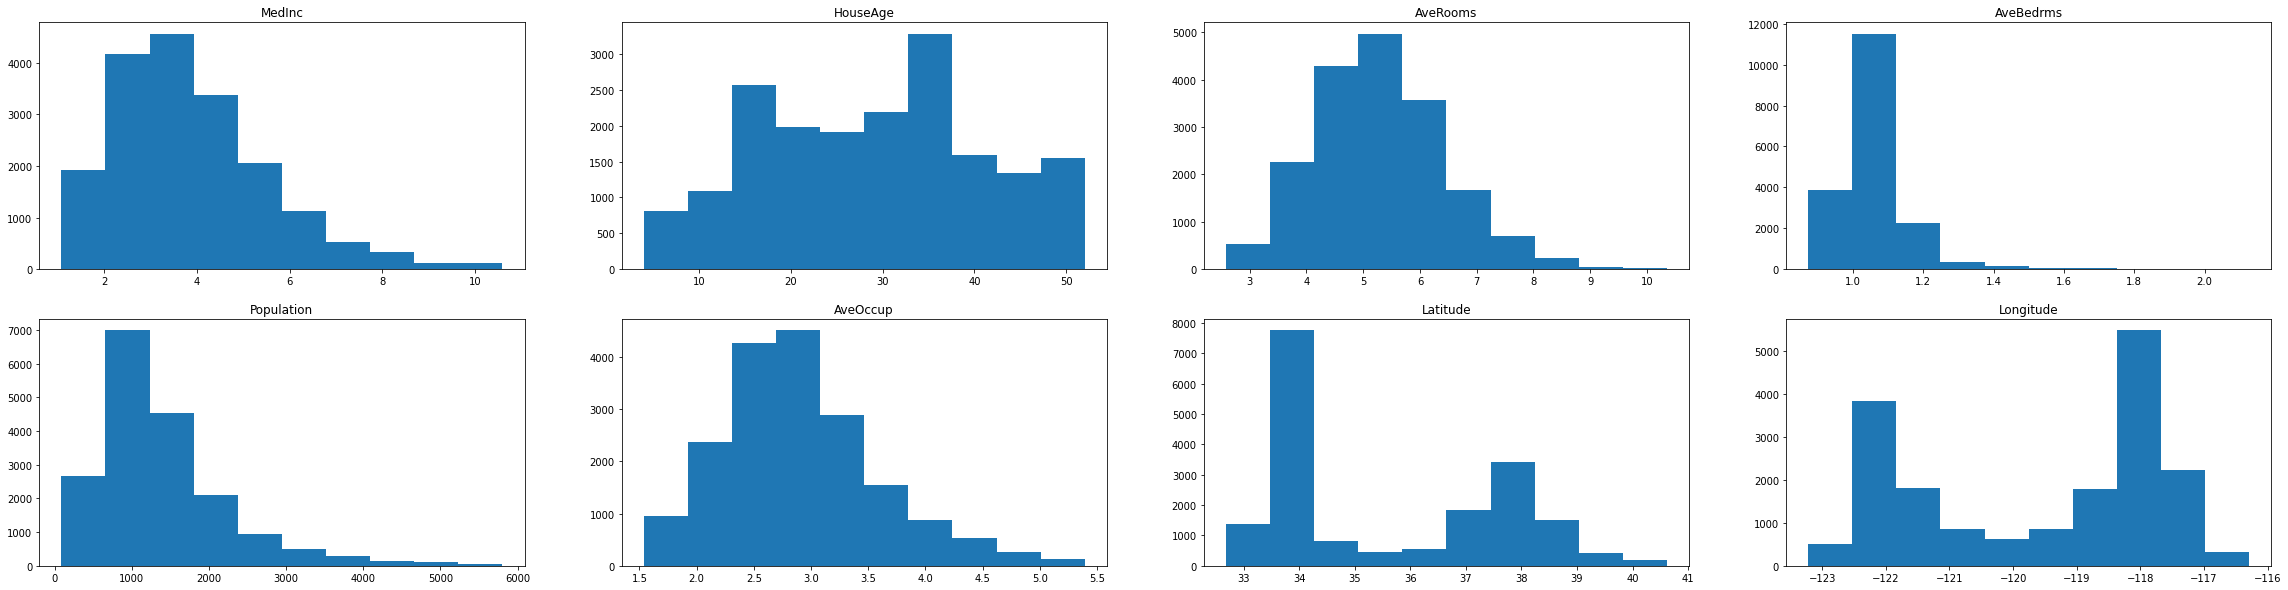

In [4]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))

for i in range(2):
    for j in range(4): 
        axs[i, j].hist(data[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
plt.show()

In [5]:
# Preprocessing 
print(data.shape)
np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]
print(X_train.shape)
print(X_test.shape)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

(18310, 8)
(12817, 8)
(5493, 8)


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z 

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [7]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 10
LATENT_DIM = 10
BATCH_SIZE = 128
N_EPOCHS = 500
lr = 1e-3

In [8]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
avg_mu_x = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + torch.exp(std_z) * eps
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x.shape

avg_mu_x = avg_mu_x.detach().numpy()

In [10]:
avg_mu_x

array([[ 0.2647568 , -0.27576554, -0.18541361, ..., -0.03360242,
        -0.06506161, -0.06553179],
       [ 0.27182227, -0.28850695, -0.18863158, ..., -0.03487124,
        -0.05992493, -0.06406696],
       [ 0.26128757, -0.2717014 , -0.19260313, ..., -0.03269405,
        -0.06731746, -0.06456354],
       ...,
       [ 0.26245376, -0.2829911 , -0.18837225, ..., -0.03272529,
        -0.06342052, -0.06673313],
       [ 0.2676612 , -0.28928638, -0.18987869, ..., -0.03229004,
        -0.06147536, -0.06548561],
       [ 0.26883906, -0.2942265 , -0.19339083, ..., -0.03121583,
        -0.06010725, -0.0660607 ]], dtype=float32)

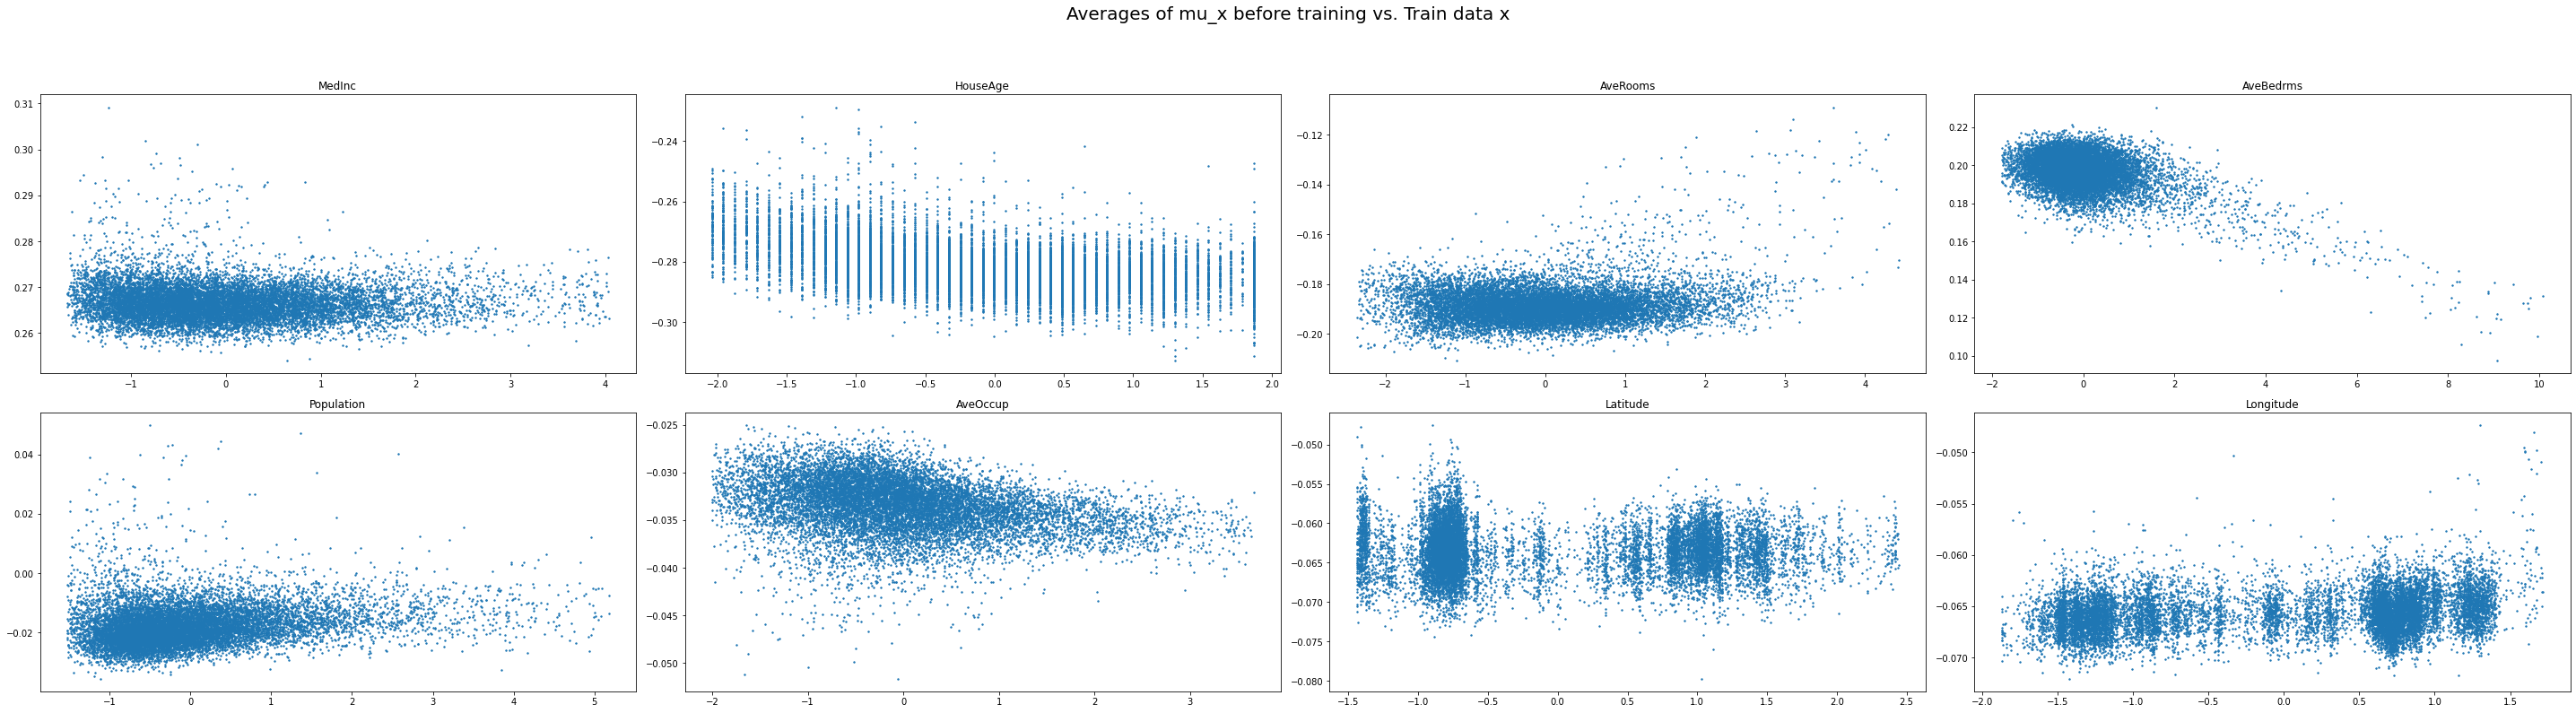

In [11]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
for i in range(2): 
    for j in range(4): 
        axs[i, j].scatter(X_train[:, i*4+j], avg_mu_x[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])

figs.tight_layout()
plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=20, y=1.1)
plt.show()

In [12]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [13]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [14]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)
test_iter = DataLoader(X_test, batch_size=BATCH_SIZE)

In [15]:
train_loss_avg = []
test_loss_avg = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x in train_iter: 
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        mu_x, std_x = dec(z_samples)
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
#     scheduler.step()
    train_loss_avg[-1] /= num_batches
    
    test_loss_avg.append(0)
    num_batches = 0
    for x_test in test_iter:
        # test
        mu_z_test, std_z_test = enc(x_test)
        eps_test = torch.randn_like(std_z_test)
        z_samples_test = mu_z_test + eps_test * torch.exp(std_z_test)

        mu_x_test, std_x_test = dec(z_samples_test)

        # loss 
        test_loss = loss_fn(mu_z_test, std_z_test, z_samples_test, mu_x_test, std_x_test, x_test)
        test_loss_avg[-1] += test_loss.item()
        num_batches += 1
    test_loss_avg[-1] /= num_batches
    
    print("Epoch [%d / %d] train loss: %f, test loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1], test_loss_avg[-1]))

Epoch [1 / 500] train loss: 11.895665, test loss: 11.504912
Epoch [2 / 500] train loss: 11.432170, test loss: 11.363330
Epoch [3 / 500] train loss: 11.320034, test loss: 11.275721
Epoch [4 / 500] train loss: 11.233268, test loss: 11.196277
Epoch [5 / 500] train loss: 11.181858, test loss: 11.160930
Epoch [6 / 500] train loss: 11.144819, test loss: 11.137621
Epoch [7 / 500] train loss: 11.136046, test loss: 11.133421
Epoch [8 / 500] train loss: 11.128227, test loss: 11.125099
Epoch [9 / 500] train loss: 11.120744, test loss: 11.121652
Epoch [10 / 500] train loss: 11.115861, test loss: 11.106159
Epoch [11 / 500] train loss: 11.109412, test loss: 11.108731
Epoch [12 / 500] train loss: 11.116305, test loss: 11.110938
Epoch [13 / 500] train loss: 11.107069, test loss: 11.108721
Epoch [14 / 500] train loss: 11.106621, test loss: 11.086100
Epoch [15 / 500] train loss: 11.102754, test loss: 11.088586
Epoch [16 / 500] train loss: 11.103643, test loss: 11.088205
Epoch [17 / 500] train loss: 11.0

Epoch [139 / 500] train loss: 8.426975, test loss: 8.365251
Epoch [140 / 500] train loss: 8.423845, test loss: 8.328571
Epoch [141 / 500] train loss: 8.443579, test loss: 8.357760
Epoch [142 / 500] train loss: 8.410418, test loss: 8.306244
Epoch [143 / 500] train loss: 8.400357, test loss: 8.308261
Epoch [144 / 500] train loss: 8.412955, test loss: 8.395248
Epoch [145 / 500] train loss: 8.408034, test loss: 8.348016
Epoch [146 / 500] train loss: 8.406557, test loss: 8.357112
Epoch [147 / 500] train loss: 8.413487, test loss: 8.324435
Epoch [148 / 500] train loss: 8.405146, test loss: 8.310579
Epoch [149 / 500] train loss: 8.405535, test loss: 8.337615
Epoch [150 / 500] train loss: 8.409562, test loss: 8.355298
Epoch [151 / 500] train loss: 8.380112, test loss: 8.336746
Epoch [152 / 500] train loss: 8.398824, test loss: 8.354831
Epoch [153 / 500] train loss: 8.413322, test loss: 8.375193
Epoch [154 / 500] train loss: 8.403847, test loss: 8.332111
Epoch [155 / 500] train loss: 8.383949, 

Epoch [276 / 500] train loss: 8.276657, test loss: 8.209193
Epoch [277 / 500] train loss: 8.289855, test loss: 8.201486
Epoch [278 / 500] train loss: 8.282404, test loss: 8.207863
Epoch [279 / 500] train loss: 8.271316, test loss: 8.193557
Epoch [280 / 500] train loss: 8.289334, test loss: 8.165596
Epoch [281 / 500] train loss: 8.269316, test loss: 8.175642
Epoch [282 / 500] train loss: 8.278402, test loss: 8.206014
Epoch [283 / 500] train loss: 8.278453, test loss: 8.180892
Epoch [284 / 500] train loss: 8.285792, test loss: 8.175043
Epoch [285 / 500] train loss: 8.284485, test loss: 8.245329
Epoch [286 / 500] train loss: 8.276627, test loss: 8.172785
Epoch [287 / 500] train loss: 8.283690, test loss: 8.192670
Epoch [288 / 500] train loss: 8.299747, test loss: 8.287028
Epoch [289 / 500] train loss: 8.301784, test loss: 8.181636
Epoch [290 / 500] train loss: 8.277557, test loss: 8.164961
Epoch [291 / 500] train loss: 8.281350, test loss: 8.195250
Epoch [292 / 500] train loss: 8.278580, 

Epoch [413 / 500] train loss: 8.199994, test loss: 8.113875
Epoch [414 / 500] train loss: 8.225220, test loss: 8.142172
Epoch [415 / 500] train loss: 8.214647, test loss: 8.140690
Epoch [416 / 500] train loss: 8.196936, test loss: 8.111149
Epoch [417 / 500] train loss: 8.176028, test loss: 8.102401
Epoch [418 / 500] train loss: 8.175874, test loss: 8.099222
Epoch [419 / 500] train loss: 8.177524, test loss: 8.089433
Epoch [420 / 500] train loss: 8.190601, test loss: 8.106448
Epoch [421 / 500] train loss: 8.172748, test loss: 8.094339
Epoch [422 / 500] train loss: 8.205455, test loss: 8.102397
Epoch [423 / 500] train loss: 8.180774, test loss: 8.119540
Epoch [424 / 500] train loss: 8.176234, test loss: 8.105810
Epoch [425 / 500] train loss: 8.177141, test loss: 8.168113
Epoch [426 / 500] train loss: 8.175607, test loss: 8.096817
Epoch [427 / 500] train loss: 8.177782, test loss: 8.145970
Epoch [428 / 500] train loss: 8.187237, test loss: 8.116491
Epoch [429 / 500] train loss: 8.183455, 

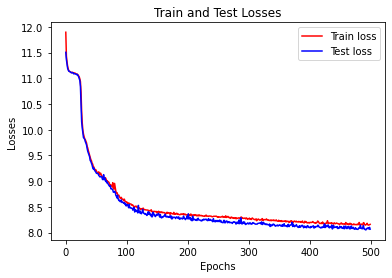

In [16]:
plt.plot(train_loss_avg, "r")
plt.plot(test_loss_avg, "b")
plt.legend(["Train loss", "Test loss"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
# plt.ylim(10, 14)
plt.title("Train and Test Losses")
plt.show()

In [17]:
avg_mu_x_trained = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_trained += mu_x

avg_mu_x_trained /= 100
avg_mu_x_trained = avg_mu_x_trained.detach().numpy()

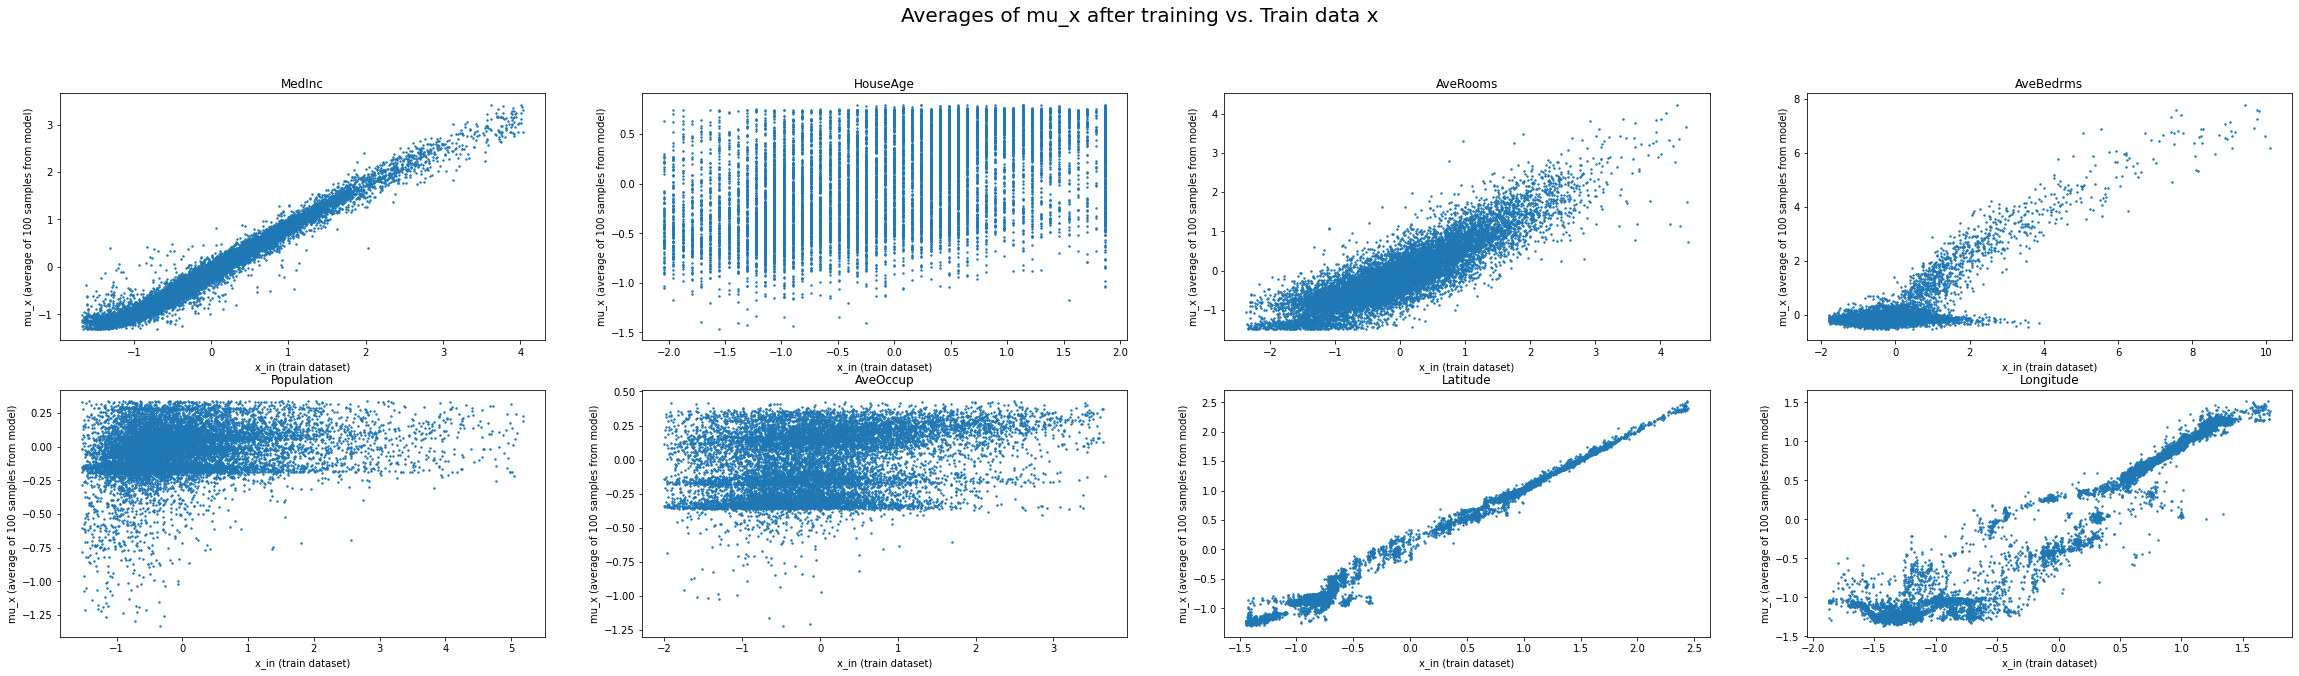

In [18]:
# avg_mu_x_trained = avg_mu_x_trained.detach().numpy()
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
count = 0 
for i in range(2):
    for j in range(4):
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x_trained[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=20, y=1)
plt.show()

In [19]:
import matplotlib.colors as mcolors
import seaborn as sns

levs = range(12)
assert len(levs) % 2 == 0, 'N levels must be even.'

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0), 
                                                          (1, 1., 1), 
                                                          (0, 0, 1)],
                                                 N=len(levs)-1)

In [20]:
p_z = torch.distributions.Normal(0, 1)
z = p_z.sample((1000, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

torch.Size([1000, 8])


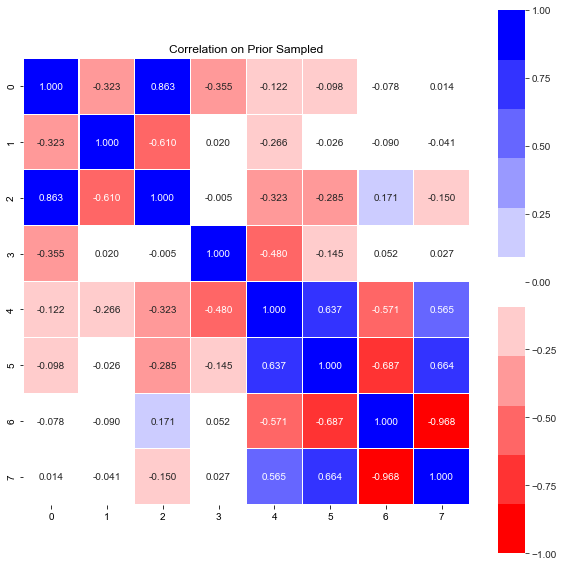

In [21]:
mu_x = mu_x.detach().numpy()
corr_eval = np.corrcoef(mu_x, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_eval, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Prior Sampled")
    plt.show()

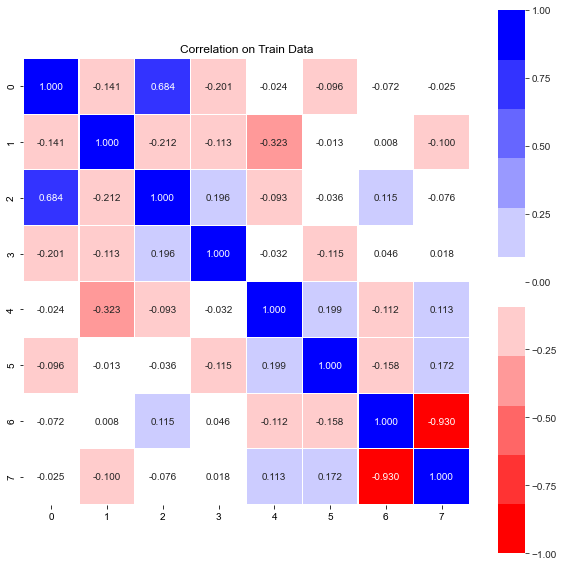

In [22]:
corr_train = np.corrcoef(X_train, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_train, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Train Data")
    plt.show()

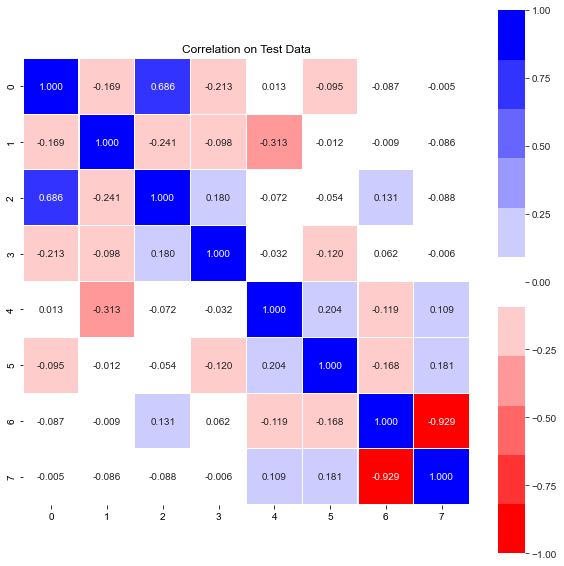

In [23]:
corr_test = np.corrcoef(X_test, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))  
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Test Data")
    plt.show()

In [24]:
# z = torch.distributions.Uniform(0, 1).sample((X_test.shape[0], LATENT_DIM)).type(torch.float64)
# mu_x, std_x = dec(z)

# # X_test = X_test.numpy()
# mu_x = mu_x.detach().numpy()

# figs, axs = plt.subplots(X_test.shape[1], 2, figsize=(20, 100))

# for i in range(X_test.shape[1]):
# #     x_test_mean = x_test[:,i].mean()
#     axs[i, 0].hist(X_test[:,i])
#     axs[i, 0].set_title("Histogram of Held Out Data on Feature " + raw_data.feature_names[i])
#     axs[i, 1].hist(mu_x[:,i])
#     axs[i, 1].set_title("Histogram of Sampled Data on Feature " + raw_data.feature_names[i])

# plt.show()